In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

In [2]:
# Morgan Fingerprints

def fingerprints_matrix(mols, nBits, radius=3):
    ''' Given a list (mols) of rdkit-encoded molecules,
        return an indicator matrix of nBit Morgan fingerprints,
        i.e. each row is the morgan vector representation of a molecule
    '''
    fp_matrix = np.zeros((len(mols), nBits))
    for m, mol in enumerate(mols):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, nBits=nBits, radius=3)
        fpOn = set(fp.GetOnBits())
        fp_matrix[m] = np.array([x in fpOn for x in range(nBits)])
    return np.array(fp_matrix, dtype=int)


def partial_svd(matrix, k, keep_shape = False):
    ''' Perform rank-k partial singular value decomposition on a matrix of shape (m x n)
        and return a matrix that approximates the original
            - If keep_shape, then the output matrix is rank k and has same shape (m x n)
            - If not keep_shape, then the output matrix has smaller shape (m x k)
        # (See: https://stats.stackexchange.com/questions/107533/)
    '''
    U, s, Vt = np.linalg.svd(matrix, full_matrices=False)
    Uk = U[:,:k]
    Sk = np.diag(s[:k])
    out = Uk @ Sk
    if keep_shape:
        Vk = Vt.T[:,:k]
        out = out @ Vk.T
    return out


def prune_fingerprints(fp_matrix, lower=0.1, upper=0.9, showPlot=False, color='green'):
    ''' Reduce fingerprint dimensions by dropping bits with frequency < lower or > upper
        Return indices of bits to keep and a pruned fp_matrix
    '''
    nMols, nBits = fp_matrix.shape
    fp_freqs = np.sum(fp_matrix, axis=0)/nMols
    fp_between = [True if lower < bit < upper else False for bit in fp_freqs]
    keep_index = np.where(fp_between)[0]
    fp_pruned = fp_matrix[:,keep_index]
    
    if showPlot:
        plt.figure(figsize=(36,12))
        plt.plot(fp_freqs, 'o-')
        plt.fill_between([0, nBits], lower, upper, color=color, alpha=0.3)
        plt.xticks(np.arange(0, nBits+1, nBits//16), size=20)
        plt.yticks(np.arange(0, 1.01, 0.1,), size=20)
        plt.grid(axis='y')
        plt.show()
        plt.close()
    
    return keep_index, fp_pruned


In [3]:
# Data normalization

def norm_unit_scale(y):
    ''' Normalize a 1D array on a 0 to 1 scale '''
    yMin, yMax = min(y), max(y)
    yRange = yMax - yMin
    return np.array([(j - yMin)/yRange for j in y]), yMin, yMax, denorm_unit_scale

def denorm_unit_scale(yNorm, yMin, yMax):
    yRange = yMax - yMin
    return np.array([j*yRange + yMin for j in yNorm])


def norm_double_unit(y):
    ''' Normalize a 1D array on a -1 to 1 scale '''
    yMin, yMax = min(y), max(y)
    halfRange = (yMax - yMin)/2
    return np.array([(j - yMin)/halfRange -1 for j in y]), yMin, yMax, denorm_double_unit

def denorm_double_unit(yNorm, yMin, yMax):
    halfRange = (yMax - yMin)/2
    return np.array([(j+1)*halfRange + yMin for j in yNorm])


def norm_z_score(y):
    ''' Normalize a 1D array by z-score '''
    mean, std = np.mean(y), np.std(y)
    return np.array([(j-mean)/std for j in y]), mean, std, denorm_z_score

def denorm_z_score(yNorm, mean, std):
    return np.array([j*std + mean for j in yNorm])


def normalize_matrix_columns(matrix, normalizer):
    return np.array([normalizer(col)[0] for col in matrix.T]).T


In [4]:
# CROW Polymer Database
crow = pd.read_csv("CROW_PolymerDatabase.csv", skiprows=2, usecols = list(range(2,9))).dropna()
crow_smiles = np.array(crow['SMILES'])
crow_mols = np.array([Chem.MolFromSmiles(sm) for sm in crow_smiles])
crow_molar_mass = np.array([Descriptors.MolWt(mol) for mol in crow_mols])
crow['Molar Mass'] = crow_molar_mass

# SMILES to Morgan Fingeprints Matrix
crow_fp_128 = fingerprints_matrix(crow_mols, 128)            # largest nBits < # polymer entries 
crow_fp_2048 = fingerprints_matrix(crow_mols, 2048)          # default nBits

# Morgan Fingerprint Density?
crow_fpDensity1 = np.array([Descriptors.FpDensityMorgan1(mol) for mol in crow_mols])
crow_fpDensity2 = np.array([Descriptors.FpDensityMorgan2(mol) for mol in crow_mols])
crow_fpDensity3 = np.array([Descriptors.FpDensityMorgan3(mol) for mol in crow_mols])

# Glass Transition Temp (Labels)
crow_Tg_Kelvin = np.array(crow['Glass Trans'])
crow_Tg_Celsius = crow_Tg_Kelvin - 273 # Celsius
crow_Tg_zScore = norm_z_score(crow['Glass Trans'])[0]
crow_Tg_unit = norm_unit_scale(crow['Glass Trans'])[0]
crow_Tg_double = norm_double_unit(crow['Glass Trans'])[0]

# Other properties
crow_prop_symbols = ['Vm', '\u03C1', '\u03C3', 'Cp', 'n', 'MM']
crow_props = np.array(crow.drop(columns=['SMILES', 'Glass Trans']))
crow_props_zScore = normalize_matrix_columns(crow_props, norm_z_score)
crow_props_unit = normalize_matrix_columns(crow_props, norm_unit_scale)
crow_props_double = normalize_matrix_columns(crow_props, norm_double_unit)

# Integerize other properties for embedding
crow_density_x100 = np.array(100*crow['Density'])
crow_hildebrand_x10 = np.array(10*crow['Hildebrand'])
crow_refract_x100 = np.array(100*crow['Refract index'])
crow_props_int = np.array([np.array(crow['Molar Volume']), crow_density_x100, crow_hildebrand_x10,
                           np.array(crow['Heat Capacity']), crow_refract_x100, crow_molar_mass], dtype=int).T

crow_ones = np.array([[1]*len(crow_Tg_Kelvin)]).T
print('database imported:\tCROW Polymer Database')
crow

database imported:	CROW Polymer Database


,SMILES,Molar Volume,Density,Hildebrand,Glass Trans,Heat Capacity,Refract index,Molar Mass
2,[*]CC[*],32.9,0.85,16.7,193.0,63.0,1.48,28.054
3,[*]CC([*])C,48.8,0.86,16.2,264.0,90.0,1.47,42.081
4,[*]CC([*])CC,65.2,0.86,16.0,245.0,118.0,1.50,56.108
5,[*]CC([*])CCC,82.5,0.85,16.3,238.0,143.0,1.47,70.135
6,[*]CC([*])CCCC,97.3,0.86,16.3,223.0,178.0,1.47,84.162
...,...,...,...,...,...,...,...,...
279,[*]CC([*])SCC,82.4,1.07,22.1,266.0,165.0,1.56,88.175
280,[*]CC([*])SCCC,99.9,1.02,17.6,253.0,195.0,1.54,102.202
281,[*]CC([*])SCCCC,118.6,0.98,17.5,253.0,225.0,1.53,116.229
282,[*]CC([*])Sc1ccccc1,118.2,1.15,19.3,386.0,152.0,1.66,136.219


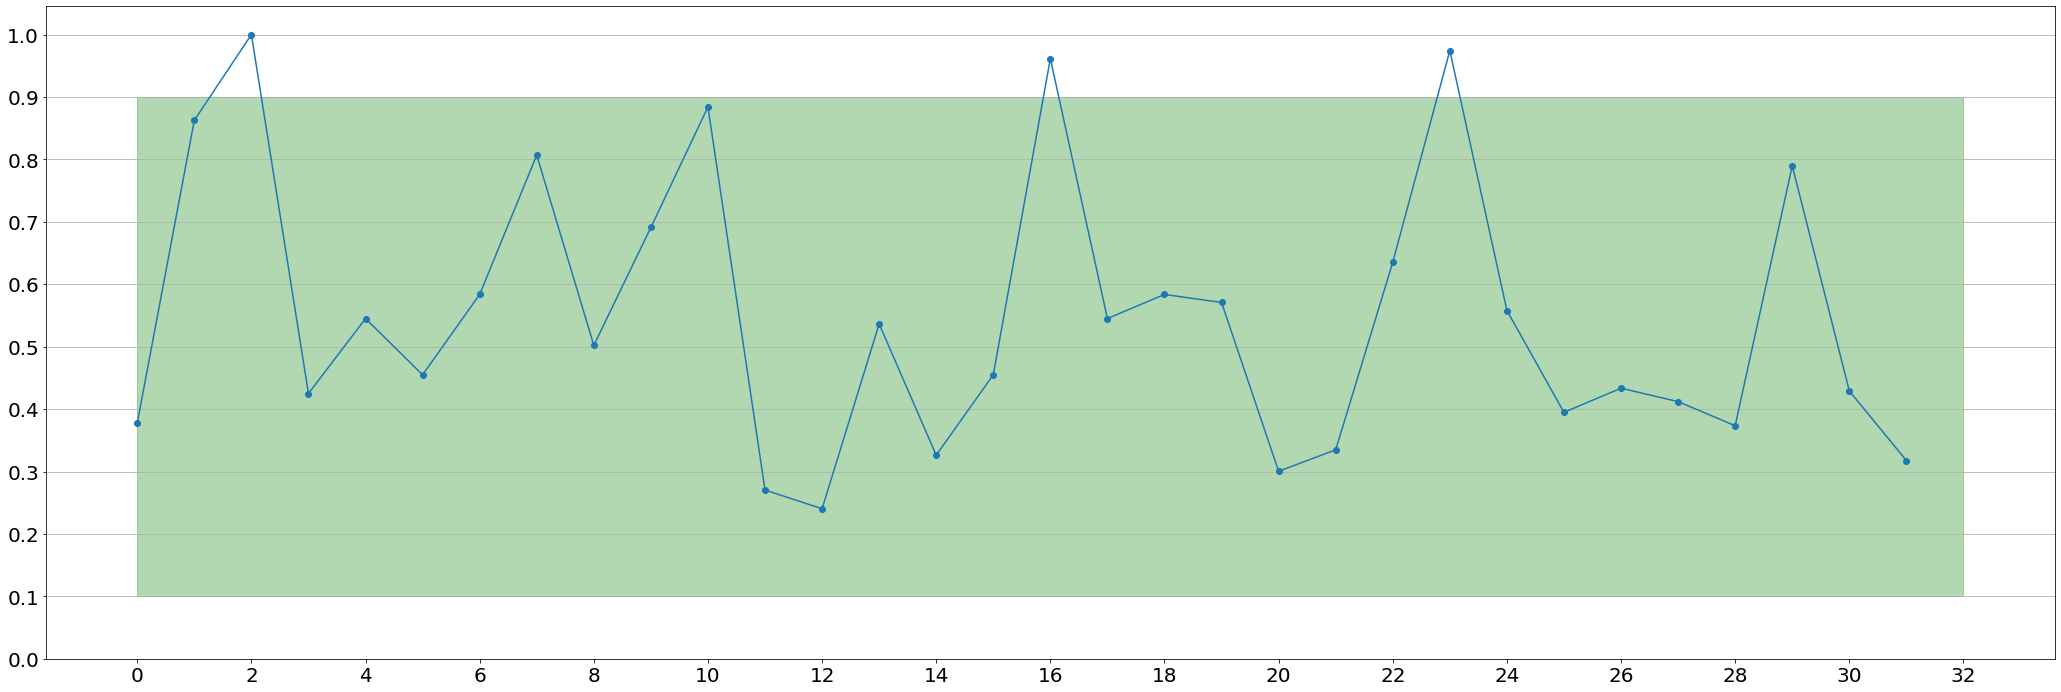

[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 24 25 26
 27 28 29 30 31]
29
0.90625
#------------------------------------------------------------------------


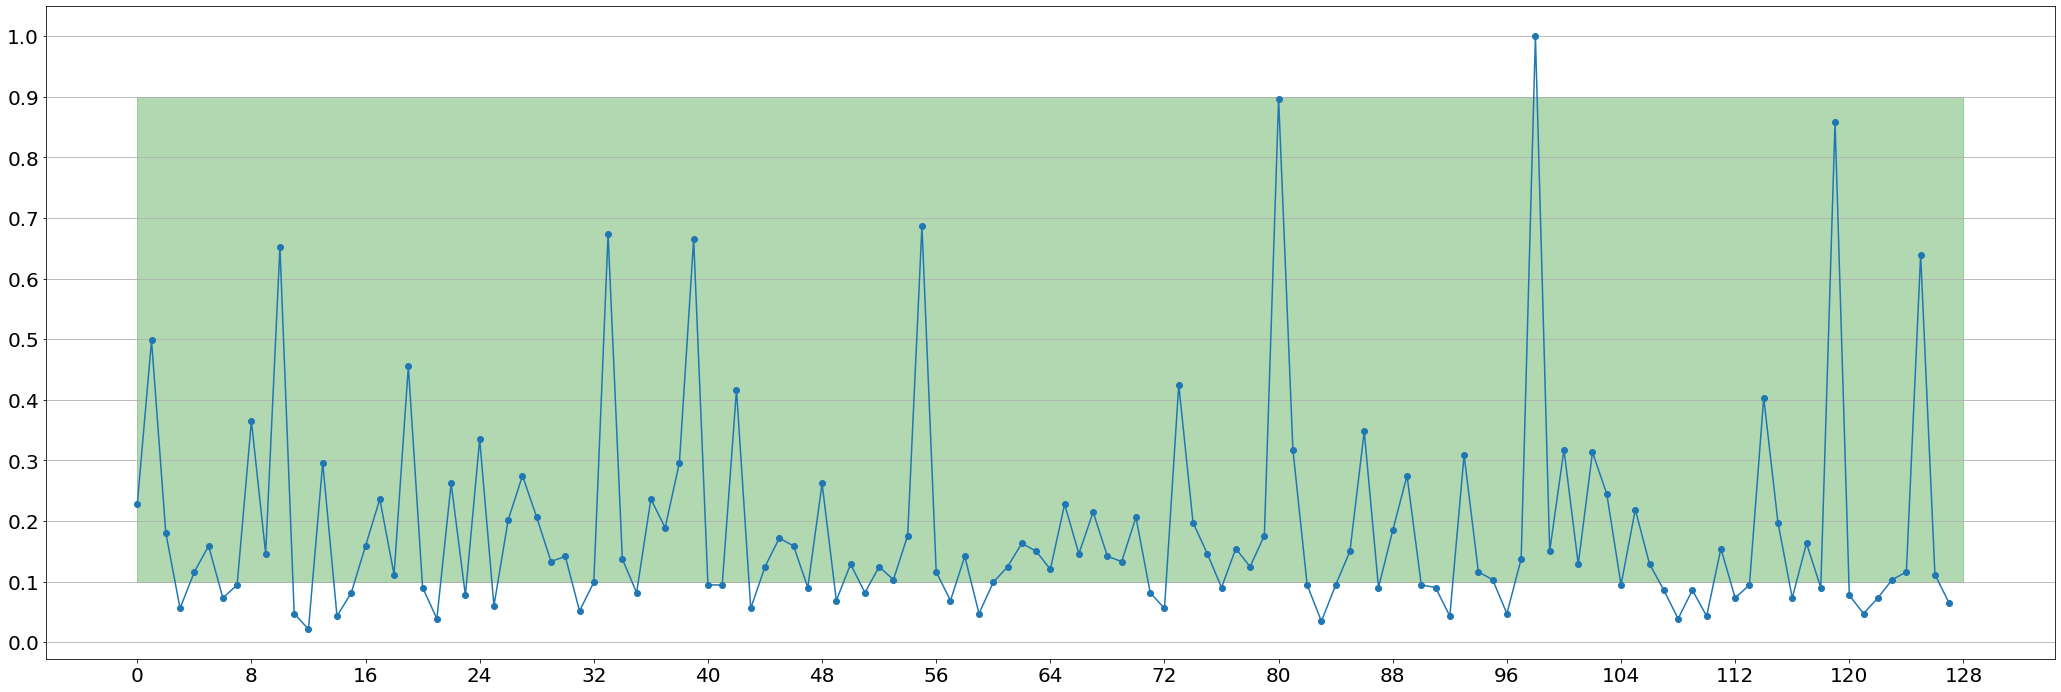

[  0   1   2   4   5   8   9  10  13  16  17  18  19  22  24  26  27  28
  29  30  33  34  36  37  38  39  42  44  45  46  48  50  52  53  54  55
  56  58  61  62  63  64  65  66  67  68  69  70  73  74  75  77  78  79
  80  81  85  86  88  89  93  94  95  97  99 100 101 102 103 105 106 111
 114 115 117 119 123 124 125 126]
80
0.625
#------------------------------------------------------------------------


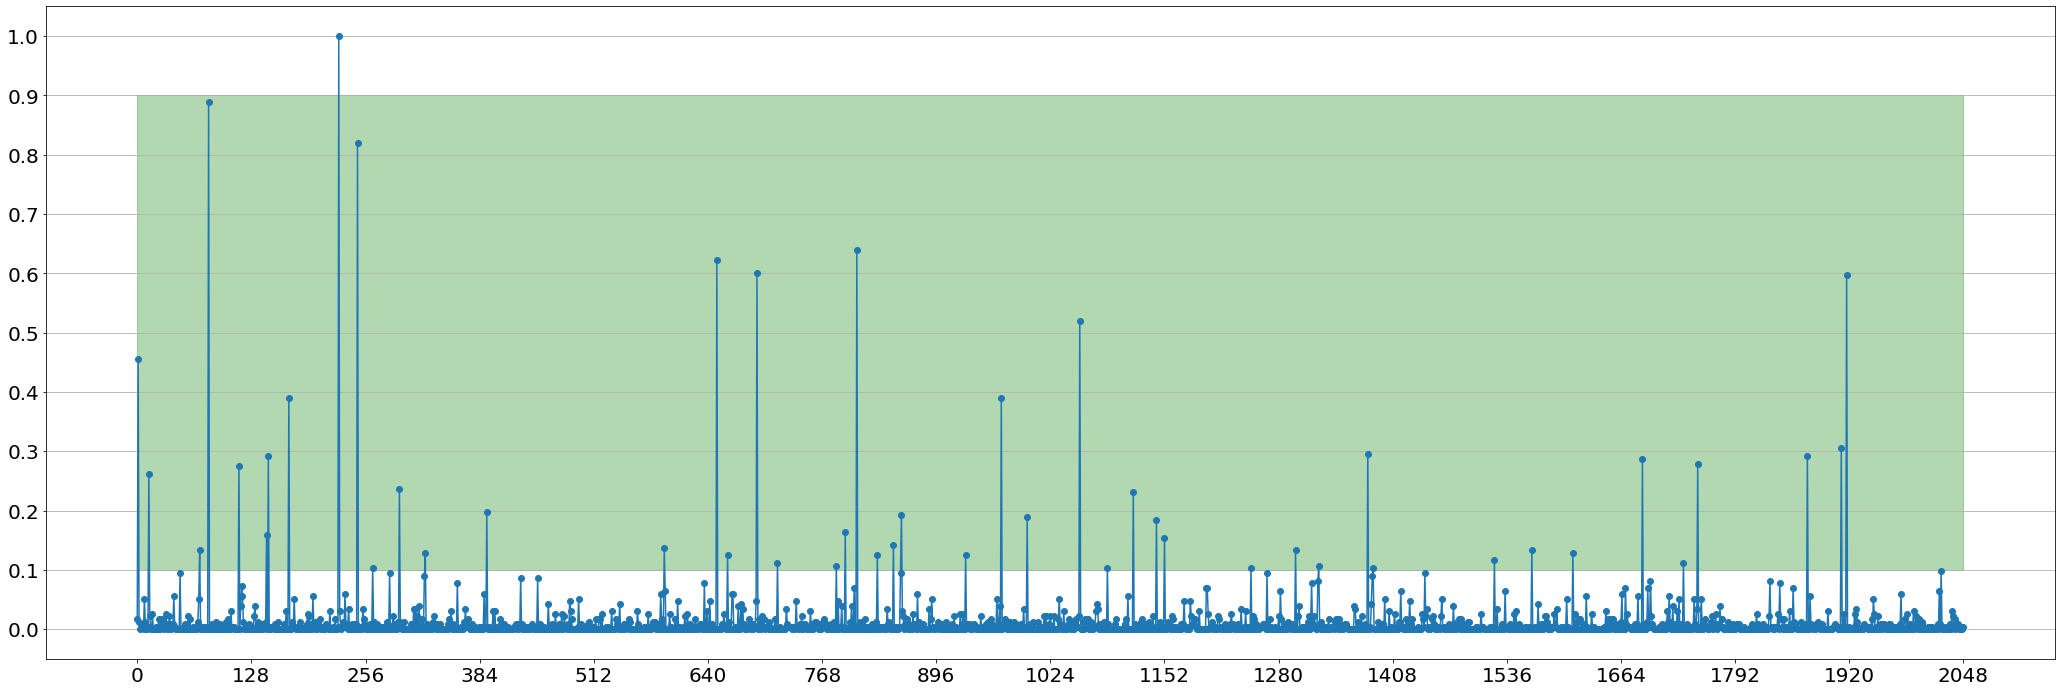

[   1   13   70   80  114  145  147  170  247  264  294  323  392  591
  650  662  695  718  784  794  807  830  848  857  929  969  998 1057
 1088 1117 1143 1152 1249 1299 1325 1380 1386 1522 1564 1610 1688 1734
 1750 1873 1911 1917]
46
0.0224609375
#------------------------------------------------------------------------


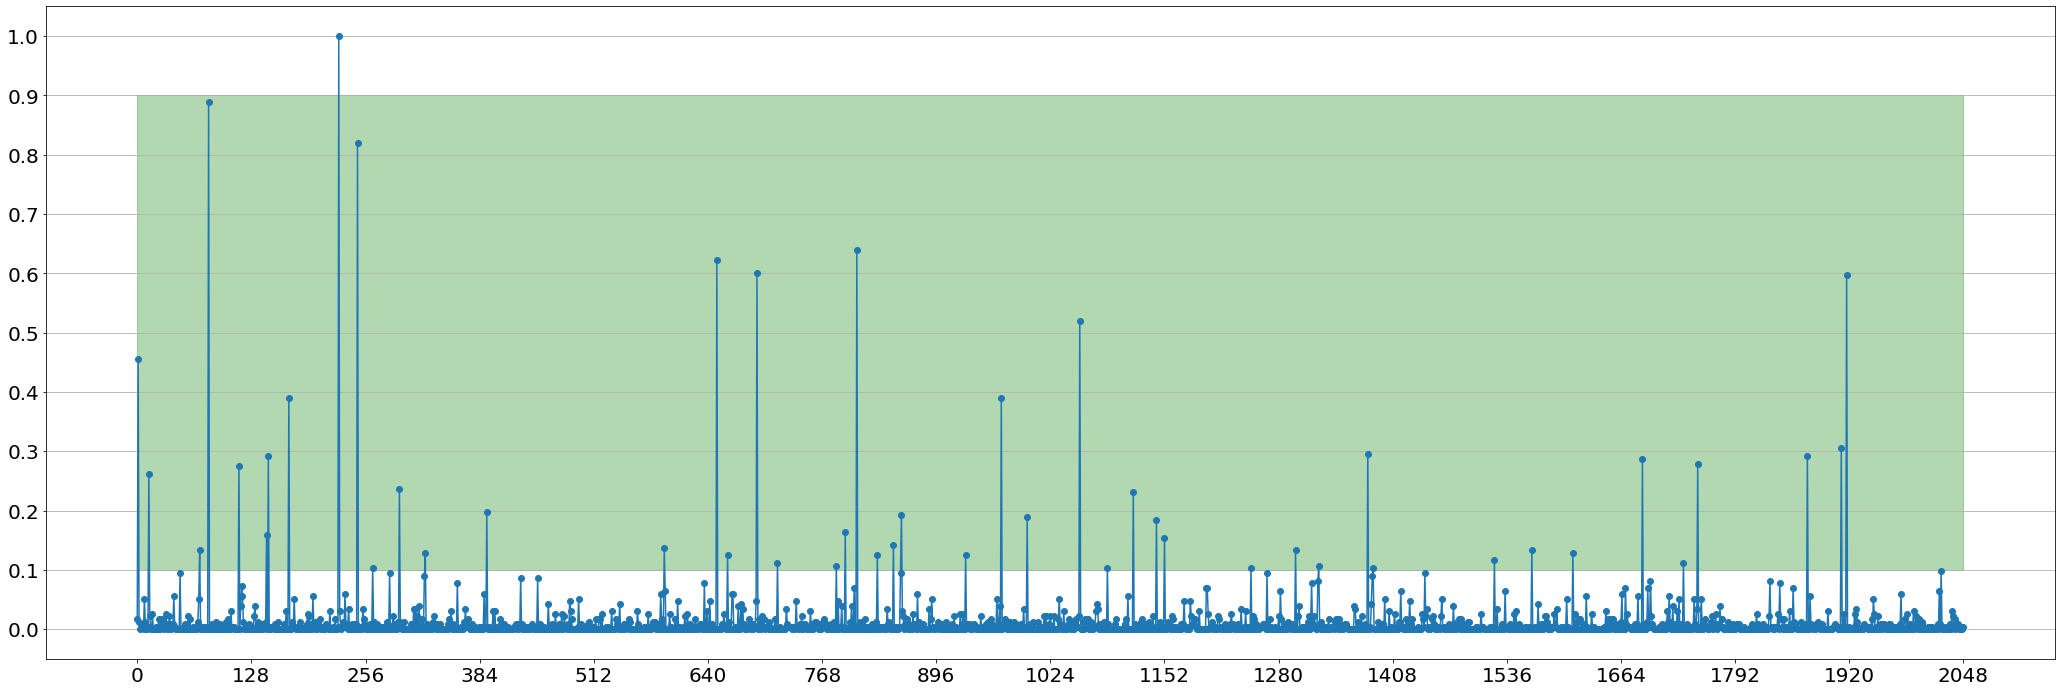

[   1   13   70   80  114  145  147  170  247  264  294  323  392  591
  650  662  695  718  784  794  807  830  848  857  929  969  998 1057
 1088 1117 1143 1152 1249 1299 1325 1380 1386 1522 1564 1610 1688 1734
 1750 1873 1911 1917]
46
0.0224609375
#------------------------------------------------------------------------


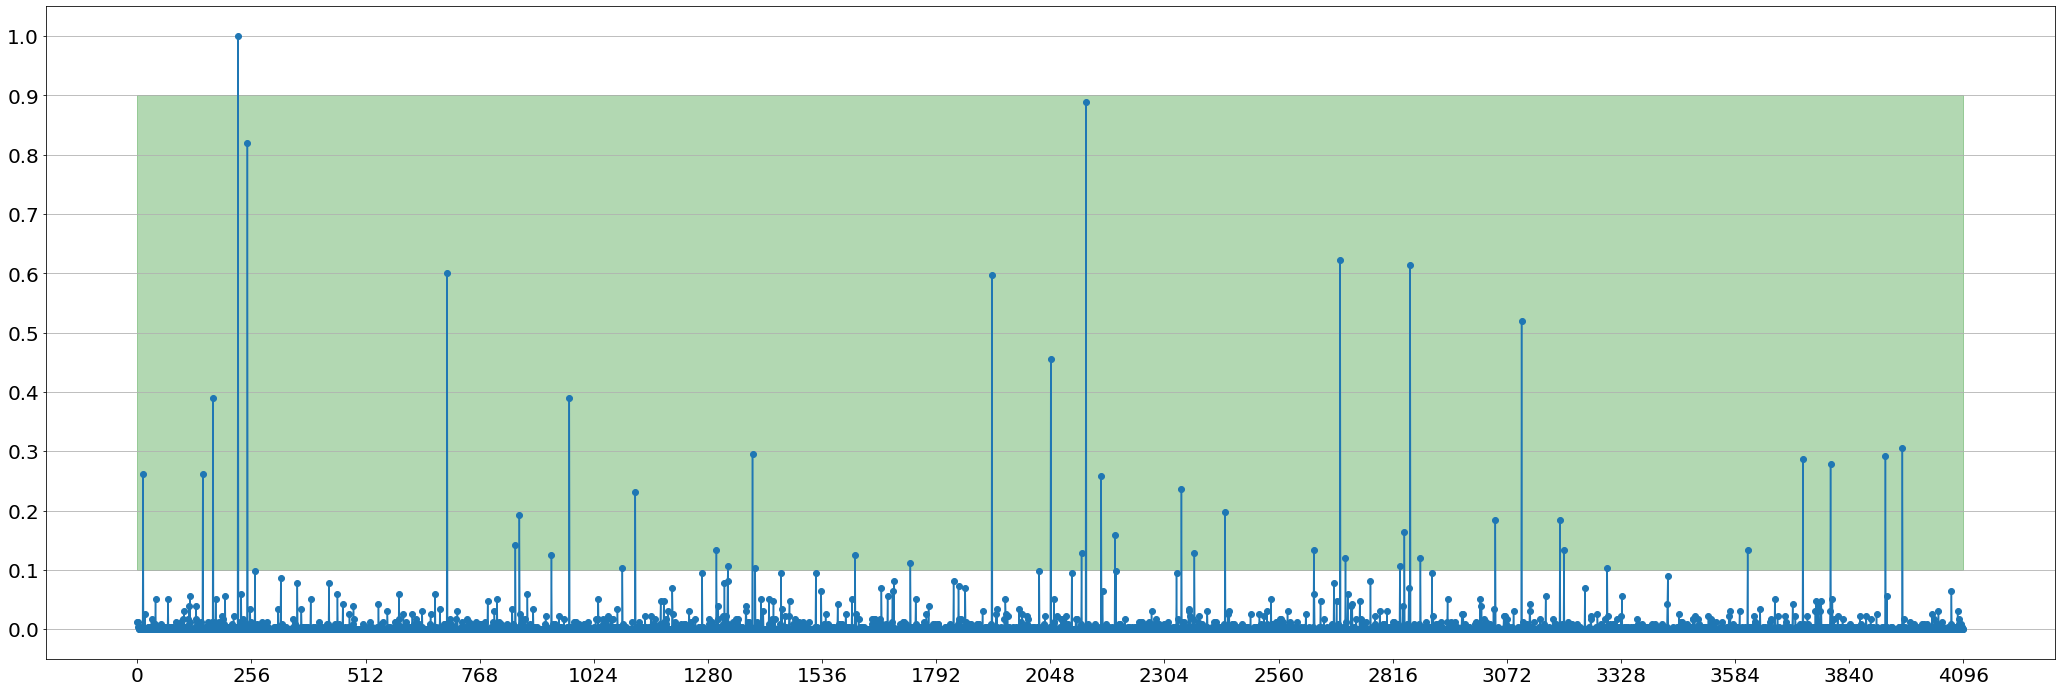

[  13  147  170  247  695  848  857  929  969 1088 1117 1299 1325 1380
 1386 1610 1734 1917 2049 2118 2128 2162 2193 2342 2371 2440 2639 2698
 2710 2832 2842 2855 2878 3046 3105 3191 3200 3297 3612 3736 3798 3921
 3959]
43
0.010498046875


In [5]:
if __name__ == "__main__" and '__file__' not in globals():
    
    # Amount of pruning increases as nBits increases:
    # look like there may already be some sort of prioritization within the Morgan alogrithm
    # i.e. more "important" fingerprints get prioritized at lower nBits while sparce fingerprints are added later
    
    idx, pruned = prune_fingerprints(fingerprints_matrix(crow_mols, 32), showPlot=True)
    print(idx)
    print(len(idx))
    print(len(idx)/32)
    print('#------------------------------------------------------------------------')
    
    # fp128_pruned keeps more bits than fp2048_pruned ???

    idx, pruned = prune_fingerprints(crow_fp_128, showPlot=True)
    print(idx)
    print(len(idx))
    print(len(idx)/128)
    print('#------------------------------------------------------------------------')
    
    idx, pruned = prune_fingerprints(crow_fp_2048, showPlot=True)
    print(idx)
    print(len(idx))
    print(len(idx)/2048)
    print('#------------------------------------------------------------------------')
    
    # Confirmed again that crow_fp_2048 === fingerprints_matrix(crow_mols, 2048) apparenty always
    # I guess the Morgan Fingerprint Algorithm, or at least the RdKit implementation, is deterministic (yay!)
    idx, pruned = prune_fingerprints(fingerprints_matrix(crow_mols, 2048), showPlot=True)
    print(idx)
    print(len(idx))
    print(len(idx)/2048)
    print('#------------------------------------------------------------------------')
    
    idx, pruned = prune_fingerprints(fingerprints_matrix(crow_mols, 4096), showPlot=True)
    print(idx)
    print(len(idx))
    print(len(idx)/4096)

In [6]:
if False: #__name__ == "__main__" and '__file__' not in globals():
    with open('crow_Tg_Celsius.csv', 'w') as f:
        for sm, tgc in zip(crow_smiles, crow_Tg_Celsius):
            f.write(f'{sm},{tgc}')
            f.write('\n')
    print('downloaded')

In [7]:
# chemprop's "Extended String Represenation"
if False: #__name__ == "__main__" and '__file__' not in globals():
    with open('crow_TgC_chemprop.csv', 'w') as f:
        f.write('Extended_String_Representation,Tg_Celsius\n')
        for sm, tgc in zip(crow_smiles, crow_Tg_Celsius):
            chemprop_str = sm.replace('[*]','[*:1]', 1).replace('[*]','[*:2]', 1) + '|1|<1-2:1:1'
            f.write(f'{chemprop_str},{tgc}\n')
    print('downloaded')

In [8]:
if __name__ == "__main__" and '__file__' not in globals():
    print(fingerprints_matrix([Chem.MolFromSmiles('[*]CC[*]')], nBits=10))
    print(fingerprints_matrix([Chem.MolFromSmiles('[*]CC[*]')], nBits=10))
    print(fingerprints_matrix([Chem.MolFromSmiles('[*]CC[*]')], nBits=10))
    print()
    print(fingerprints_matrix([Chem.MolFromSmiles('CC')], nBits=10))
    print(fingerprints_matrix([Chem.MolFromSmiles('CC')], nBits=10))
    print(fingerprints_matrix([Chem.MolFromSmiles('CC')], nBits=10))

[[0 1 1 0 0 0 1 0 0 1]]
[[0 1 1 0 0 0 1 0 0 1]]
[[0 1 1 0 0 0 1 0 0 1]]

[[0 1 0 0 0 0 0 1 0 0]]
[[0 1 0 0 0 0 0 1 0 0]]
[[0 1 0 0 0 0 0 1 0 0]]


Col Min-Maxes: (24, 416) (9, 213) (123, 320) (60, 745) (122, 171) (28, 456) 

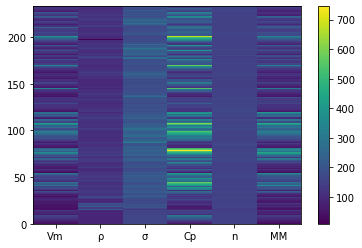

In [9]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.pcolormesh(crow_props_int)
    plt.xticks(np.arange(6)+0.5, crow_prop_symbols)
    plt.colorbar()
    
    print('Col Min-Maxes:', end=' ')
    for col in crow_props_int.T:
        print((min(col), max(col)), end=' ')

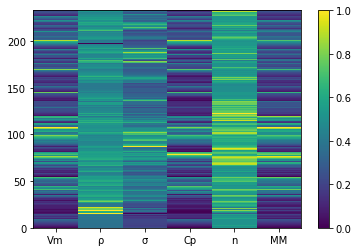

In [10]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.pcolormesh(crow_props_unit)
    plt.xticks(np.arange(6)+0.5, crow_prop_symbols)
    plt.colorbar()

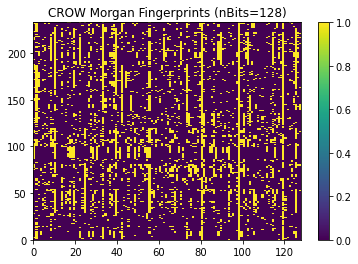

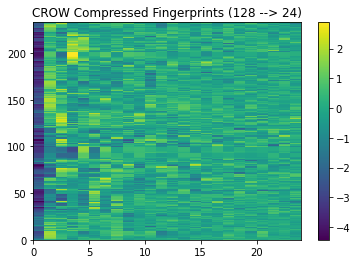

In [11]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.title('CROW Morgan Fingerprints (nBits=128)')
    plt.pcolormesh(crow_fp_128)
    plt.colorbar()
    
    plt.figure()
    plt.title('CROW Compressed Fingerprints (128 --> 24)')
    plt.pcolormesh(partial_svd(crow_fp_128, 24))
    plt.colorbar()

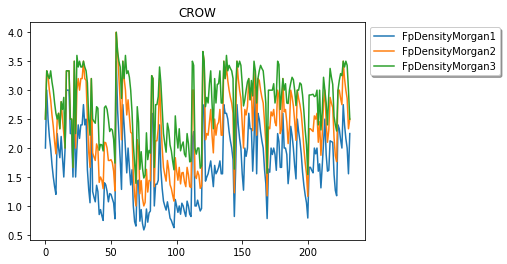

In [12]:
if __name__ == "__main__" and '__file__' not in globals():
    plt.title('CROW')
    plt.plot(crow_fpDensity1, label='FpDensityMorgan1')
    plt.plot(crow_fpDensity2, label='FpDensityMorgan2')
    plt.plot(crow_fpDensity3, label='FpDensityMorgan3')
    plt.legend(bbox_to_anchor=(1,1), shadow=True)

[169 136 161  52 148 210  48 101 105 157  95 195]


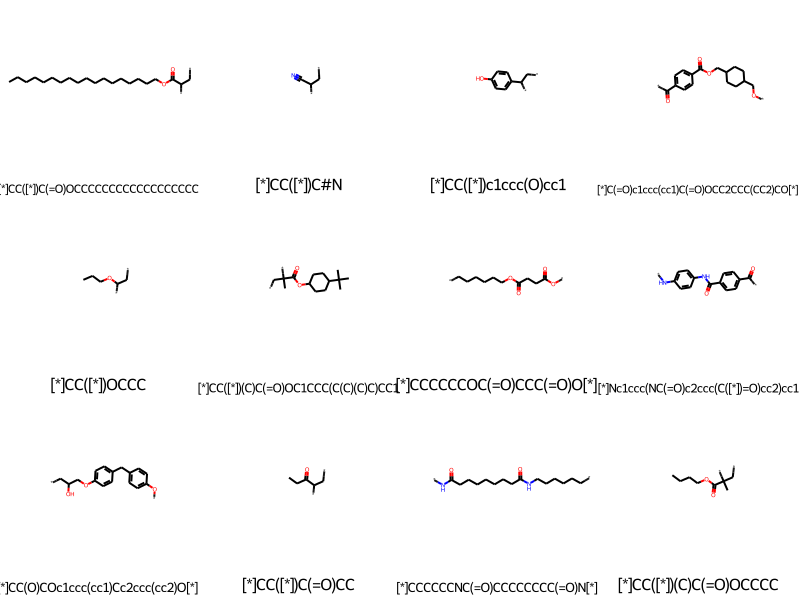

done


In [13]:
if __name__ == "__main__" and '__file__' not in globals():
    n_list = len(crow_smiles)
    some_mol_indices = np.random.choice(n_list, replace=False, size=12)
    print(some_mol_indices)
    some_mols = crow_mols[some_mol_indices]
    some_smiles = crow_smiles[some_mol_indices]
    some_drawings = Draw.MolsToGridImage(some_mols, molsPerRow=4, legends=list(some_smiles))
    display(some_drawings)
    print('done')